# Multinomial logistic regression

Multinomial logistic regression is used to predict categorical placement in or the probability of category membership on a dependent variable based on multiple independent variables. The independent variables can be either dichotomous (i.e., binary) or continuous (i.e., interval or ratio in scale). Multinomial logistic regression is a simple extension of binary logistic regression that allows for more than two categories of the dependent or outcome variable. Like binary logistic regression, multinomial logistic regression uses maximum likelihood estimation to evaluate the probability of categorical membership.   

Multinomial logistic regression does necessitate careful consideration of the sample size and examination for outlying cases. Like other data analysis procedures, initial data analysis should be thorough and include careful univariate, bivariate, and multivariate assessment. Specifically, multicollinearity should be evaluated with simple correlations among the independent variables. Also, multivariate diagnostics (i.e. standard multiple regression) can be used to assess for multivariate outliers and for the exclusion of outliers or influential cases. Sample size guidelines for multinomial logistic regression indicate a minimum of 10 cases per independent variable (Schwab, 2002).  

In [3]:
import copy, math
import numpy as np
import pandas as pd
import csv
import ast
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Output
from plt_overfit import overfit_example, output
from lab_utils_logistic import sigmoid
from features import *
import cv2
# plt.style.use('./deeplearning.mplstyle')

As any of the other regression algorithms we need a cost function, a gradient function and finally we will use it to do our approximation with the gradient descent algorithm.

### Cost function (logistic)
_____

We will reuse the same cost function that we developed for binary logistic regression

In [4]:
def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """

    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
             
    cost = cost/m                                                      #scalar

    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          #scalar
    reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
    total_cost = cost + reg_cost                                       #scalar
    return total_cost    

Let´s test it just to make sure it is as expected.

In [5]:
np.random.seed(1)
X_tmp = np.random.rand(5,6)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1]).reshape(-1,)-0.5
b_tmp = 0.5
lambda_tmp = 0.7
cost_tmp = compute_cost_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print("Regularized cost:", cost_tmp)

Regularized cost: 0.6850849138741673


### Gradient function (logistic)
_____
We will also reuse the gradient function

In [6]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)            : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw  

Let's also test it.

In [7]:
np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"dj_db: {dj_db_tmp}", )
print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )

dj_db: 0.341798994972791
Regularized dj_dw:
 [0.17380012933994293, 0.32007507881566943, 0.10776313396851499]


### Gradient descent 
_____

In [8]:
def gradient_descent(X, y, w_in, b_in, alpha, r_lambda, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      r_lambda (float)     : Regularization rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic_reg(X, y, w, b, r_lambda)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic_reg(X, y, w, b, r_lambda) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history

In [9]:
x_train = np.random.rand(7,100)
y_train = np.array([0, 0, 0, 1, 1, 1, 1])

w_in = np.random.rand(x_train.shape[1])
b_in = 0.5

alph = 0.1
r_lambda = 0.7
iters = 10000

w_out, b_out, _ = gradient_descent(x_train, y_train, w_in, b_in, alph, r_lambda, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 12.739934913837264   
Iteration 1000: Cost 0.281653557844575   
Iteration 2000: Cost 0.2805544529528461   
Iteration 3000: Cost 0.28001755576326876   
Iteration 4000: Cost 0.2797552637963744   
Iteration 5000: Cost 0.2796271167365323   
Iteration 6000: Cost 0.27956450532341226   
Iteration 7000: Cost 0.2795339129360169   
Iteration 8000: Cost 0.27951896491109185   
Iteration 9000: Cost 0.2795116608954348   

updated parameters: w:[-0.02  0.42 -0.    0.02  0.13 -0.13 -0.06 -0.43 -0.1   0.01  0.08 -0.1
  0.07 -0.05 -0.1   0.16  0.11 -0.1   0.14 -0.16  0.09 -0.31 -0.1   0.03
  0.16  0.06  0.05 -0.01  0.12  0.01  0.09 -0.15  0.28 -0.27  0.22 -0.06
  0.11 -0.09  0.15 -0.04  0.06 -0.23 -0.08 -0.03 -0.14 -0.19  0.2   0.2
  0.19 -0.01 -0.   -0.29  0.05  0.02  0.02  0.08 -0.04  0.02 -0.06  0.11
  0.13 -0.12 -0.15 -0.06  0.03  0.17  0.14 -0.23  0.19 -0.31 -0.21 -0.11
 -0.04  0.1   0.03 -0.29 -0.14  0.13 -0.05  0.29 -0.01 -0.18 -0.13 -0.09
 -0.39 -0.1  -0.06  0.11  0.25 -0.15

## The changes

The implementation of Multiclass classification follows the same ideas as the binary classification. In multi-class classification, we have more than two classes. Here is an example. Say, we have different features and characteristics of cars, trucks, bikes, and boats as input features. Our job is to predict the label(car, truck, bike, or boat). We will treat each class as a binary classification problem; this approach is called the __one vs all method__.

In the one vs all method, when we work with a class, that class is denoted by 1 and the rest of the classes becomes 0. For example, if we have four classes: cars, trucks, bikes, and boats. When we will work on the car, we will use the car as 1 and the rest of the classes as zeros. Again, when we will work on the truck, the element of the truck will be one, and the rest of the classes will be zeros

| Car | Truck | Bike | Boat |
| --- | --- | --- | --- |
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 |


We will make one column for each of the classes with the same length as y. When the class is truck, we will make a column that has 1 for the rows with trucks and 0 otherwise.

We will create a function that will produce a temporary y vector that will only have 1's for the selected class, and 0's for the rest.

In [10]:
def y_change(y, cl):
    """
    Creates an independent y vector that only holds 1's for
    the selected class and zero for the rest
    
    Args:
      y (ndarray (m,)) : target values
      cl (scalar)      : The class we are studying.
      
    Returns:
      y_pr (ndarray (n,))   : Array holding only 1's for the 
                              analyzed class.
    """
    y_pr=[]
    for i in range(0, len(y)):
        if y[i] == cl:
            y_pr.append(1)
        else:
            y_pr.append(0)
    return y_pr

We will create a function that will produce the w values that will separate the i-th class

In [11]:

#x = [[featuresImage1],[feturesImage2],[feturesImage3]]
#y = [0,1,2]
def find_param(X, y):
    """
    Creates the w_i vector for the given class.
    
    Args:
      X (ndarray (m,n)    : Data, m examples with n features
      y (ndarray (m,))    : Target values
      
    Returns:
      theta_list (ndarray (n,)) : This is a matrix that will hold a row for the w values
                                  for every i class. 
    """
    alph = 0.1
    r_lambda = 0.7
    iters = 1000

    y_uniq = list(set(y.flatten()))
    theta_list = []
    for i in y_uniq:
        w_in = np.random.rand(X.shape[1])
        b_in = 0.5

        y_tr = pd.Series(y_change(y, i))
        # y_tr = y_tr[:, np.newaxis]
        np.array(y_tr)[:, np.newaxis]
        print(f"\n\nWe will find the weights for class: {i}")
        theta1, _ , _ = gradient_descent(X, y_tr, w_in, b_in, alph, r_lambda, iters) 
        theta_list.append(theta1)
    return theta_list

Finally, we will create a function that should give us the proper class for every entry.

In [12]:
def predict(theta_list, X, y):

    y_uniq = list(set(y.flatten()))
    y_hat = [0]*len(y)
    for i in range(0, len(y_uniq)):
        y_tr = y_change(y, y_uniq[i])
        # y1 = sigmoid(x, theta_list[i])
        y1 = sigmoid(np.dot(X, theta_list[i]))
        for k in range(0, len(y)):

            if y_tr[k] == 1 and y1[0] >= 0.2:
                y_hat[k] = y_uniq[i]

    return y_hat

In [13]:
#load images
labels = ['Cubism', 'Graffiti', 'PopArt']
#features
x_train = []
#labels
y_train = []
norm = 0
with open("ImagesData.csv", 'r') as file:
    csv_reader = csv.reader(file)
    flag = True
    flagNorm = True
    
    for row in csv_reader:
        if(flag):
            flag = False
            continue
        if(row == []):
            continue
        x = np.array(ast.literal_eval(row[2]))
        # x+=1
        # x = np.log10(x)+1
        #norm = np.linalg.norm(x)
        if(flagNorm):
            flagNorm = False
            norm = np.linalg.norm(x)
        
        x_train.append(x/norm)
        if(row[1] == 'Cubism'):
            y_train.append(0)
        if(row[1] == 'Graffiti'):
            y_train.append(1)
        if(row[1] == 'PopArt'):
            y_train.append(2)
y_train = np.array(y_train)
x_train = np.array(x_train)
pass


Let's test it. First, we will create the list of our weights for each class.

In [14]:

theta_list = find_param(x_train, y_train)




We will find the weights for class: 0
Iteration    0: Cost 1.325208878053607   
Iteration  100: Cost 0.753579738845259   
Iteration  200: Cost 0.7500204319388691   
Iteration  300: Cost 0.7465893051968648   
Iteration  400: Cost 0.7432732485089175   
Iteration  500: Cost 0.7400669023596756   
Iteration  600: Cost 0.7369652057492613   
Iteration  700: Cost 0.7339633797506057   
Iteration  800: Cost 0.7310569118004402   
Iteration  900: Cost 0.7282415406292574   


We will find the weights for class: 1
Iteration    0: Cost 1.1454408621424363   
Iteration  100: Cost 0.7615949753875837   
Iteration  200: Cost 0.7591164848393396   
Iteration  300: Cost 0.7566914737643587   
Iteration  400: Cost 0.754314320127904   
Iteration  500: Cost 0.7519840279094883   
Iteration  600: Cost 0.7496996251261648   
Iteration  700: Cost 0.7474601629795863   
Iteration  800: Cost 0.7452647151230061   
Iteration  900: Cost 0.7431123769606701   


We will find the weights for class: 2
Iteration    0: Cost 1.

In [35]:
f = open("data.py", "w")
f.write("import numpy as np\n")
f.write("norm = "+str(norm)+"\n")
f.write("theta_list = "+str(theta_list).replace("array","np.array"))
f.close()

Now that we have it, we can run our prediction.

In [15]:
#original
# y_hat = predict(theta_list, x_train, y_train)
# def predict2(theta_list, X, y):

#     y_uniq = list(set(y.flatten()))
#     y_hat = [0]*len(y)
#     for i in range(0, len(y_uniq)):
#         y_tr = y_change(y, y_uniq[i])
#         # y1 = sigmoid(x, theta_list[i])
#         y1 = sigmoid(np.dot(X, theta_list[i]))
#         for k in range(0, len(y)):

#             if y_tr[k] == 1 and y1[0] >= 0.2:
#                 y_hat[k] = y_uniq[i]

#     return y_hat
def predict2(theta_list, X):
    y_hat = 0
    y1 = sigmoid(np.dot(X, theta_list))
    y_hat = y1[0]
    return y1[0]

In [16]:
#intentar predecir

image = cv2.imread(".\Testing\Extras\gray.png")
features = np.array([getFeatures(image)])

# ximage = np.array([features/norm,features/norm,features/norm])
ximage = np.array(features/norm)
# Cubism = 0
# Graffiti = 1
# PopArt = 2

yimage = np.array([0,1,2])
        # if(row[1] == 'Cubism'):
        #     y_train.append(0)
        # if(row[1] == 'Graffiti'):
        #     y_train.append(1)
        # if(row[1] == 'PopArt'):
        #     y_train.append(2)
y_hat1 = predict2(theta_list[0], ximage)
y_hat2 = predict2(theta_list[1], ximage)
y_hat3 = predict2(theta_list[2], ximage)
# y_hat = predict(theta_list, ximage, yimage)
print("mean0: ",np.mean(theta_list[0]))
print("mean1: ",np.mean(theta_list[1]))
print("mean2: ",np.mean(theta_list[2]))
print("y_hat1:",y_hat1)
print("y_hat2:",y_hat2)
print("y_hat3:",y_hat3)

pass

mean0:  0.4520042526707984
mean1:  0.4665208558603517
mean2:  0.43916643627230495
y_hat1: 0.3341056104431478
y_hat2: 0.41099875195838437
y_hat3: 0.6600940447402058


In [17]:
y_hat

NameError: name 'y_hat' is not defined

We can now even observe the results.

NameError: name 'y_hat' is not defined

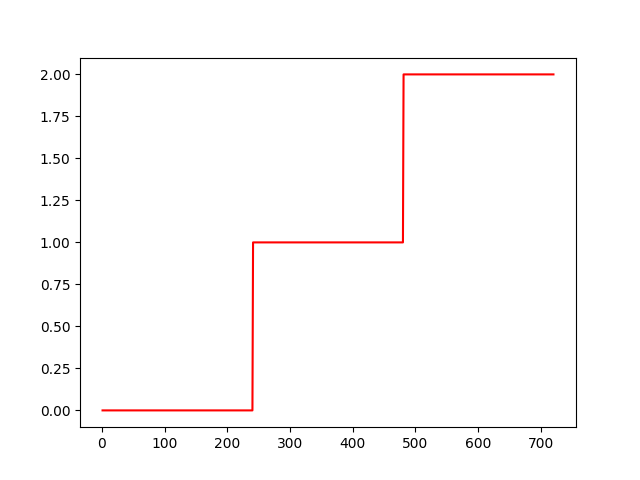

In [18]:
#Plotting the actual and predicted values
f1 = plt.figure()
c = [i for i in range (1,len(y_train)+1,1)]
plt.plot(c,y_train,color='r',linestyle='-')
plt.plot(c,y_hat,color='b',linestyle='-')
plt.xlabel('Value')
plt.ylabel('Class')
plt.title('Actual vs. Predicted')
plt.show()

NameError: name 'y_hat' is not defined

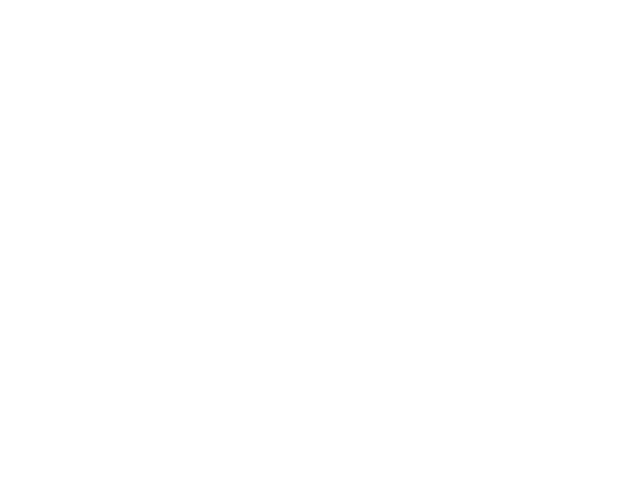

In [19]:
#Plotting the error
f1 = plt.figure()
c = [i for i in range(1,len(y_train)+1,1)]
plt.plot(c,y_train-y_hat,color='green',linestyle='-')
plt.xlabel('index')
plt.ylabel('Error')
plt.title('Error Value')
plt.show()